In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import RobustScaler
import seaborn as sb
import pandas as pd
from replaceNA import *
from sklearn import model_selection

In [2]:
df = pd.read_csv('WeatherSydney.csv', sep = ';', index_col = "Date")
df.head()

,Location,Rainfall,WindGustDir,WindGustSpeed,WindSpeed3pm,Humidity3pm,Pressure3pm,Cloud3pm,Temp3pm
Date,,,,,,,,,
01.02.2008,Sydney,15.6,NaN,NaN,20.0,84.0,1017.4,8.0,20.9
02.02.2008,Sydney,6.0,NaN,NaN,13.0,73.0,1016.4,7.0,24.8
03.02.2008,Sydney,6.6,NaN,NaN,2.0,86.0,1015.6,8.0,23.0
04.02.2008,Sydney,18.8,NaN,NaN,20.0,90.0,1011.8,8.0,20.9
05.02.2008,Sydney,77.4,NaN,NaN,6.0,74.0,1004.8,8.0,25.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3337 entries, 01.02.2008 to 25.06.2017
Data columns (total 9 columns):
Location         3337 non-null object
Rainfall         3331 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity3pm      3324 non-null float64
Pressure3pm      3318 non-null float64
Cloud3pm         2776 non-null float64
Temp3pm          3333 non-null float64
dtypes: float64(7), object(2)
memory usage: 260.7+ KB


In [4]:
df = df.drop(columns = ['WindGustDir', 'WindGustSpeed'])

In [5]:
df.head()

,Location,Rainfall,WindSpeed3pm,Humidity3pm,Pressure3pm,Cloud3pm,Temp3pm
Date,,,,,,,
01.02.2008,Sydney,15.6,20.0,84.0,1017.4,8.0,20.9
02.02.2008,Sydney,6.0,13.0,73.0,1016.4,7.0,24.8
03.02.2008,Sydney,6.6,2.0,86.0,1015.6,8.0,23.0
04.02.2008,Sydney,18.8,20.0,90.0,1011.8,8.0,20.9
05.02.2008,Sydney,77.4,6.0,74.0,1004.8,8.0,25.5


In [6]:
df.describe()

,Rainfall,WindSpeed3pm,Humidity3pm,Pressure3pm,Cloud3pm,Temp3pm
count,3331.000000,3312.000000,3324.000000,3318.000000,2776.000000,3333.000000
mean,3.330231,19.335447,54.699158,1016.018774,4.218660,21.533333
std,9.895172,7.482554,16.293530,7.032211,2.641885,4.303737
min,0.000000,0.000000,10.000000,989.800000,0.000000,10.200000
25%,0.000000,15.000000,44.000000,1011.300000,1.000000,18.400000
50%,0.000000,19.000000,56.000000,1016.300000,4.000000,21.300000
75%,1.400000,24.000000,65.000000,1020.800000,7.000000,24.500000
max,119.400000,57.000000,99.000000,1036.700000,8.000000,44.700000


In [7]:
df = df.dropna()

## Корреляции

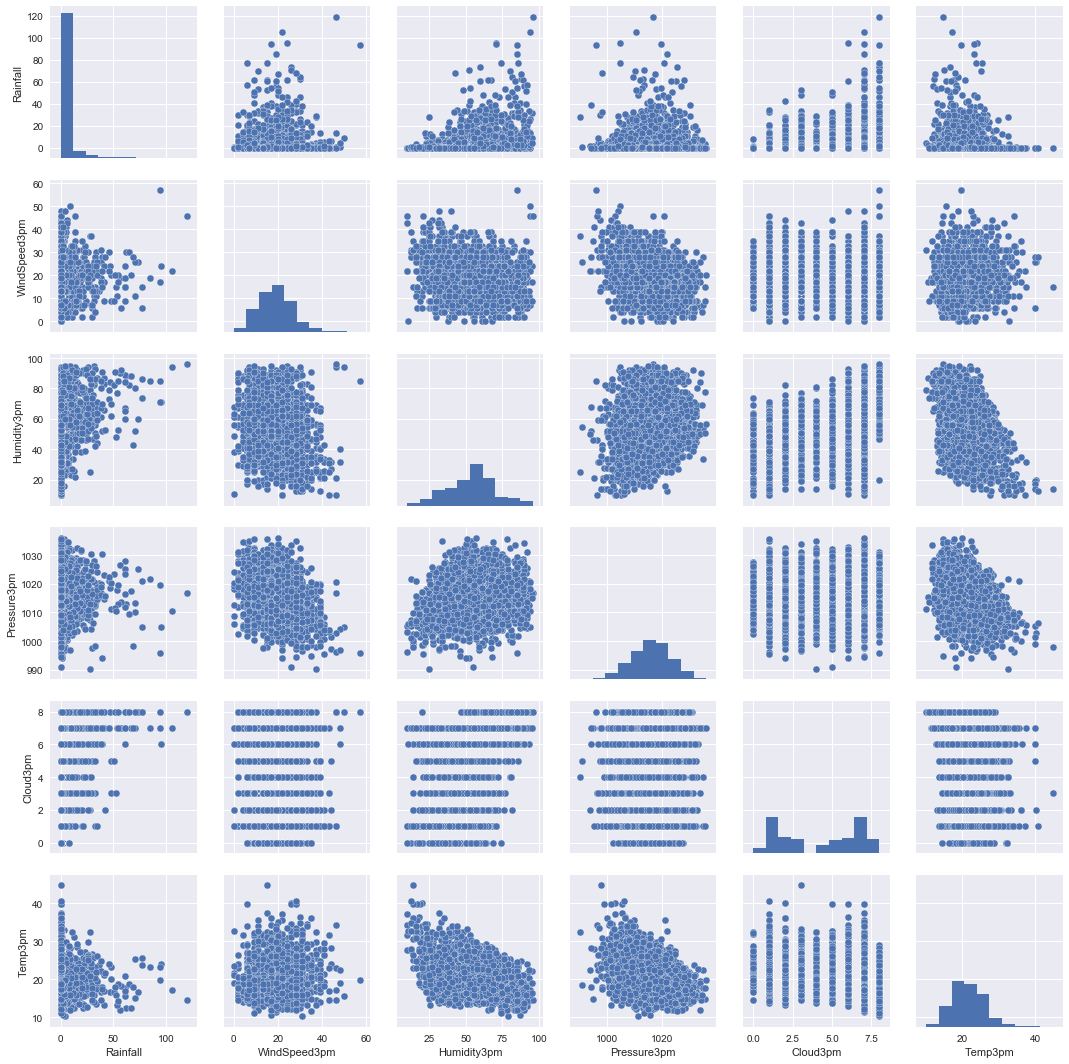

In [8]:
sb.set(style= 'darkgrid', context = 'notebook')
sb.pairplot(df, size=2.5)
plt.show()

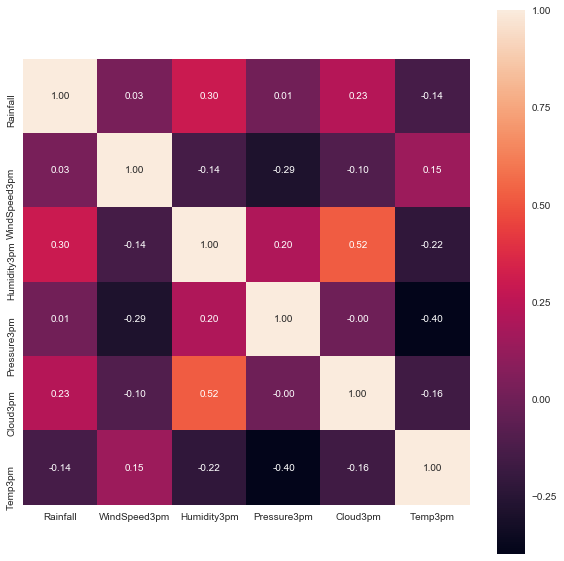

In [10]:
def plot_correlation(data, columns):
    cm = np.corrcoef(data.T)
    plt.figure(figsize=(10,10))
    heatmap = sb.heatmap(cm, cbar=True, annot=True, square=True,
                         fmt='.2f', annot_kws={'size':10}, xticklabels=columns, yticklabels=columns)
    
plot_correlation(df.iloc[:,1:], df.columns[1:])

Как видим, переменные в датасете плохо коррелируют между собой :(

## Распределения основных переменных

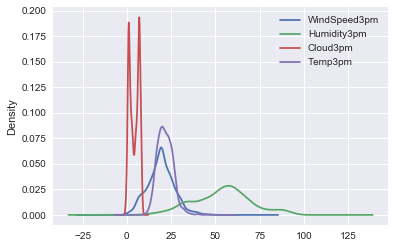

In [11]:
df.iloc[:, [2,3,5,6]].plot.density()

## Boxplots

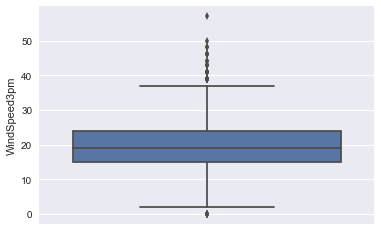

In [12]:
sb.boxplot(y = df['WindSpeed3pm'])

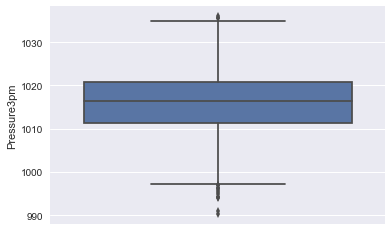

In [13]:
sb.boxplot(y = df['Pressure3pm'])

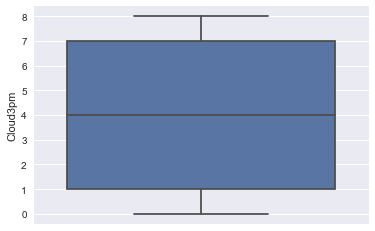

In [14]:
sb.boxplot(y = df['Cloud3pm'])

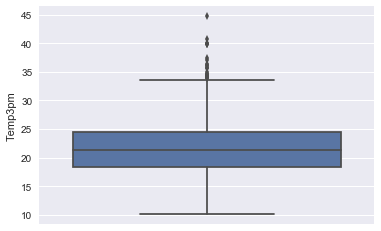

In [15]:
sb.boxplot(y = df['Temp3pm'])

In [16]:
X = df.values[:, 1:-1]
y = df.values[:, -1]
#Удаление выбросов, масштабирование
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
X_scaled = rs.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, shuffle=True, random_state=42)

In [17]:
#Метрика R2
def test_model_r2(model, X_train, X_test, y_train, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

In [35]:
#линейная регрессия
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
r2 = test_model_r2(lin_reg, X_train, X_test, y_train, y_test)
print(r2)

#Додано
cv = model_selection.cross_val_score(lin_reg, X_train, y_train, cv=15, scoring='r2')
print("Mean: %f\nSTD: %f" % (cv.mean(), cv.std()))

0.19713471469855448
Mean: 0.179075
STD: 0.062303


In [34]:
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.0001, l1_ratio=0.1)

r2 = test_model_r2(enet, X_train, X_test, y_train, y_test)

print(r2)


#Додано
cv = model_selection.cross_val_score(enet, X_train, y_train, cv=15, scoring='r2')
print("Mean: %f\nSTD: %f" % (cv.mean(), cv.std()))

0.19713567500231743
Mean: 0.179077
STD: 0.062291


In [36]:
#SGDRegressor
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(alpha=0.00001, max_iter=1000, tol=0.0001, shuffle=True, random_state=100)

r2 = test_model_r2(sgd_reg, X_train, X_test, y_train, y_test)

print(r2)


#Додано
cv = model_selection.cross_val_score(sgd_reg, X_train, y_train, cv=15, scoring='r2')
print("Mean: %f\nSTD: %f" % (cv.mean(), cv.std()))

0.1106892605704437
Mean: 0.100512
STD: 0.125694


## Вывод

LinearRegression и ElasticNet (R2 = 0,19) дали лучший результат, чем SGDRegressor (R2 = 0,11). Однако в силу того, что данные плохо коррелируют получаем и низкие значения R2.